# Modeling

We model the quality of tweets as well as the likelihood of a tweet to contain news.

### Feature Creation

- event-independent
    - meta
    - content
    - social
        - tweet
        - user
    - lexical
    - semantic
- event-dependent
    - time
    - content
    - semantic
    
### Evaluate Features

- using $\chi^2$ test of independence
    
### Setup Pipeline
- Multinomial Naive Bayes
    - 
- K Nearest Neighbor
    - 
- Decision Tree
    - Decision trees learn branching rules from features.
- Random Forest
    - A random forest is a collection of decision trees. Each tree is trained using a random sample of the dataset. The prediction is an average of all the predictions made by the trees.
- Support Vector Classifier
    - 

### Run Pipeline
- specify class to predict
    - News (0,1)
    
*We discard those values which were annotated as unclear and model on those which were identified as news or non-news content. This clearer sepearation in our data increase the accuracy of the model, although requires more data to be annotated.*

### Results

- graph each model's results by three measures
    - Accuracy
    - Precision
    - Recall

### Evaluate Results
- interpretation of results
    - Accuracy
        - Classification accuracy is the number of correct predictions made divided by the total number of predictions made. This is studied as the jaccard similarity score.
    - Precision
        - fraction of correctly predictive positives to all predicted as positives: $\frac{true positives}{true postivies + false positives}$
    - Recall
        - fraction of correctly predicted positives to all positives: $\frac{true posisitves}{true positives + false negatives}$
    - F1 Score
        - weighted average of precision and recall, from 0 to 1: $\frac{2 \cdot (precision \cdot recall)}{precision + recall}$

Accepting certain results from the above can depend on application. Specifically, we try to combat the [**accuracy paradox**](https://en.wikipedia.org/wiki/Accuracy_paradox) which is relevant to datsets of unbalanced class distribution. Given a dataset of large class unbalance, the classifier will predict the dominant class majority of the time and result in high accuracy. Although this accuracry is misleading because it simply represents the underlying class distribution. Alternatively, we look at further measures of evaluation.

If the applications requires high degree of certainty for those positive predictions actually being positive then **high precsion** is most important. If the application requires the prediciton of as many positive examples as possible then **high recall** will be most important. The former application could accept some positive examples being misclassified as negative and the latter could accept some negative example being misclassified as positive.

For the application of event summarization on Twitter, we consider the scenario of needing learn as much newsworthy information as possible in a short amount of time. Our process should present only only that content only which is of high probability of being newsworthy and ignore that which is not. Therefore we are interested in **maximizing precision**, and can likely dismiss recall due to the volume of data we have access to.

In addition to looking at precision, we apply the technique of **undersampling** to create a more balanced dataset for classifying. By simply dropping some of data from the dominant class we can boost the representation of the underrepresented class. This will in turn create a more meaninful accuracy score. This technique is available due to the volume of data we are able to annotate through crowdsourcing.

#### import tools

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import nltk
import html
import string
import ast
from textblob import TextBlob

#### import classification annotations

In [2]:
#REAL DATA
#cf = pd.read_csv('data/final/tweet_annotations_agg.csv', sep='\t', encoding='utf-8', header=0)
#cf.shape
#REAL TEST DATA
cf = pd.read_csv('data/final/final_data_classified.txt', sep='\t', encoding='utf-8', header=0)
cf.shape

(4798, 6)

#### import event data
- for each event name import event data
- create dictionary of { Event Name : Pandas DataFrame }

In [3]:
data = {}
for event_name in cf['event'].unique():
    event_filename = re.sub("\W+", "", event_name.strip())
    data[event_name] = pd.read_csv('data/final/event_%s_data.txt' % event_filename, sep='\t', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
    
allevents = list(data.values())

df = pd.concat(allevents)
df.drop_duplicates(subset='twitter_id', inplace=True)
#df.rename(columns={'master_id' : 'event_id'}, inplace=True)
df.shape

(1053377, 37)

#### merge annotations to data
- using event name and event id
- integity of twitter id was lost during annotation (crowdflower did not support such a long integer)

In [4]:
df = pd.merge(df, cf[['event', 'event_id', 'news']], how='inner', on=['event', 'event_id'])
df.shape

(4768, 37)

#### set index

In [5]:
df.set_index('twitter_id', inplace=True)

#### created clean text field

In [6]:
%%time
#convert text to string
#remove hashtag, mention symbols, any links
df['text_clean'] = df['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in html.unescape(str(text)).replace('#', '').replace('@', '').split()]))
#initiate, apply tokenization
tknzr = nltk.TweetTokenizer()
df['text_clean'] = df['text_clean'].apply(lambda text: ' '.join([w.lower() for w in tknzr.tokenize(text)]))

Wall time: 232 ms


## feature creation

#### feature list
- **event-independent**
    - **meta**
        - source_web_client
        - source_tweetdeck
        - source_iphone
        - source_android
        - has_location
    - **content**
        - tweet_type
        - possibly_sensitive
        - count_entities_media
        - media_per_word
        - count_entities_urls
        - urls_per_word
        - count_entities_mentions
        - mentions_per_word
        - count_entities_hashtags
        - hashtags_per_word
    - **social**
        - **tweet**
            - is_retweet
            - is_reply
            - is_quoted_tweet
            - favorite_count
            - retweet_count
            - engagements
            - engagements_per_word
            - favorite_count_eventstdz
            - retweet_count_eventstdz
            - engagements_count_eventstdz
        - **user**
            - user_default_profile
            - user_default_profile_image
            - user_verified
            - user_statuses
            - user_favourites
            - user_followers
            - user_friends
            - user_listed
            - user_bio_len
            - user_reputation
            - user_age_days
            - user_follower_rate
    - **lexical**
        - count_characters
        - count_non_characters
        - count_upper
        - count_tokens
        - count_stops
        - question
        - elongation
        - ellipsis
        - lexical_diversity
        - sfpp
        - pfpp
        - count_named_entities
        - unique_named_entities
        - count_parts_of_speech
        - unique_parts_of_speech
    - **semantic**
        - text_sentiment_positive
        - text_sentiment_negative
        - text_sentiment_subjective
- **event-dependent**
    - **pulse**
        - frequency_1min
        - rollmean_frequency_win5min
        - rollmean_frequency_deviation
    - **content**
        - media_weight
        - url_weight
        - mention_weight
        - hashtag_weight
    - **semantic**
        - term_weight
        - tfidf_sum
        - tfidf_mean
        - event_centroid_distance

## Event-Independent
### Meta

In [7]:
%%time
df['source_web_client'] = df['tweet_type'].apply(lambda s: [0,1][s=='Twitter Web Client'])
df['source_tweetdeck'] = df['tweet_type'].apply(lambda s: [0,1][s=='TweetDeck'])
df['source_iphone'] = df['tweet_type'].apply(lambda s: [0,1][s=='Twitter for iPhone'])
df['source_android'] = df['tweet_type'].apply(lambda s: [0,1][s=='Twitter for Android'])
df['has_location'] = df['longitude'].apply(lambda l: [1,0][np.isnan(l)])

Wall time: 28.5 ms


### Content

In [8]:
%%time
df['tweet_type'] = df['tweet_type'].apply(lambda d: [0,1][d=='media'])
df['possibly_sensitive'] = df['possibly_sensitive'].apply(lambda d: [0,1][d==True])

df['count_entities_media'] = df['entities_media'].apply(lambda media: len(media))
df['media_per_word'] = df.apply(lambda row: row['count_entities_media'] / len(row['text'].split()), axis=1)

df['count_entities_urls'] = df['entities_urls'].apply(lambda urls: len(urls))
df['urls_per_word'] = df.apply(lambda row: row['count_entities_urls'] / len(row['text'].split()), axis=1)

df['count_entities_mentions'] = df['entities_mentions'].apply(lambda mentions: len(mentions))
df['mentions_per_word'] = df.apply(lambda row: row['count_entities_mentions'] / len(row['text'].split()), axis=1)

df['count_entities_hashtags'] = df['entities_hashtags'].apply(lambda tags: len(tags))
df['hashtags_per_word'] = df.apply(lambda row: row['count_entities_hashtags'] / len(row['text'].split()), axis=1)

Wall time: 1.99 s


### Social
#### Tweet

In [9]:
%%time
#created by twitter
    #is_retweet
    #is_reply
    #is_quoted_tweet
    #favorite_count
    #retweet_count
df['engagements'] = df['favorite_count'] + df['retweet_count']
df['engagements_per_word'] = df.apply(lambda row: row['engagements'] / len(row['text'].split()), axis=1)

#normalize tweet social data to event distribution
#NOTE: this is only relative to training documents
df['favorite_count'] = df.groupby('event')['favorite_count'].transform(lambda x: x / x.max())
df['retweet_count'] = df.groupby('event')['retweet_count'].transform(lambda x: x / x.max())
df['engagements'] = df.groupby('event')['engagements'].transform(lambda x: x / x.max())
#df['favorite_count_eventstdz'] = df.groupby('event')['favorite_count'].transform(lambda x: (x - x.mean()) / x.std())
#df['retweet_count_eventstdz'] = df.groupby('event')['retweet_count'].transform(lambda x: (x - x.mean()) / x.std())
#df['engagements_eventstdz'] = df.groupby('event')['engagements'].transform(lambda x: (x - x.mean()) / x.std())

Wall time: 505 ms


#### User

In [10]:
%%time
df['user_verified'] = df['user_verified'].apply(lambda d: [0,1][d==True])
df['user_default_profile'] = df['user_default_profile'].apply(lambda d: [0,1][d==True])
df['user_default_profile_image'] = df['user_default_profile_image'].apply(lambda d: [0,1][d==True])
#created by twitter
    #user_followers
    #user_friends
df['user_reputation'] = df['user_followers'] / (df['user_friends'])
df['user_reputation'].replace(np.inf, np.nan, inplace=True)
df['user_bio_len'] = df['user_description'].apply(lambda bio: len(str(bio)))
df['user_age_days'] = df.apply(lambda doc: (doc['created_at'] - pd.to_datetime(doc['user_created_at'])).days, axis=1)
df['user_follower_rate'] = df['user_followers'] / df['user_age_days']
df['user_follower_rate'].replace(np.inf, np.nan, inplace=True)

Wall time: 1.28 s


### Lexical

In [11]:
%%time
#create stop words list
stop = nltk.corpus.stopwords.words('english')
punct = list(string.punctuation)
punct.extend(['...', '..', '…', '”', '“', '.@', 'RT'])
stop.extend(punct)
#create elongated regular expression (>= 3 letters in a row)
elongation = re.compile("([a-zA-Z])\\1{2,}")

df['count_characters'] = df['text'].apply(lambda text: len(str(text)))
df['count_non_characters'] = df['text'].apply(lambda text: len(re.sub('[\w+!@#$%&;:,.?\/\-“”’`"\'()|]', '', text).strip()))
df['count_upper'] = df['text'].apply(lambda text: len([l for l in ' '.join([w for w in text.split() if not w.startswith(('#', '@'))]) if l.isupper()]))
df['count_tokens'] = df['text_clean'].apply(lambda text: len(text.split()))
df['mean_token_length'] = df['text_clean'].apply(lambda text: np.mean([len(t) for t in text.split()]))
df['mean_token_frequency'] = df['text_clean'].apply(lambda text: np.mean(list(Counter(text.split()).values())))
df['count_tokens_stopped'] = df['text_clean'].apply(lambda text: len([t for t in text.split() if t not in stop]))
df['count_stops'] = df['text_clean'].apply(lambda text: len([t for t in text.split() if t in stop]))
df['count_question_marks'] = df['text_clean'].apply(lambda text: text.split().count('?'))
df['elongation'] = df['text_clean'].apply(lambda text: [0,1][bool(elongation.search(text))])
df['ellipsis'] = df['text_clean'].apply(lambda text: 1 if any(x in text for x in ('...', '…')) else 0)
df['lexical_diversity'] = df['text_clean'].apply(lambda text: len(set(text.split())) / len(text.split()))

# singular first person pronoun
sfpp = ['i', 'i\'m', 'me', 'mine', 'my', 'myself']
df['sfpp'] = df['text_clean'].apply(lambda text: 1 if any(t.lower() in sfpp for t in text.split()) else 0)
# plural first person pronoun
pfpp = ['we', 'we\'re', 'ours', 'our', 'ourselves']
df['pfpp'] = df['text_clean'].apply(lambda text: 1 if any(t.lower() in pfpp for t in text.split()) else 0)

Wall time: 959 ms


### Semantic

In [12]:
%%time
df['text_sentiment_polarity'] = df['text_clean'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)
df['text_sentiment_positive'] = df['text_sentiment_polarity'].apply(lambda s: [0,abs(s)][s > 0])
df['text_sentiment_negative'] = df['text_sentiment_polarity'].apply(lambda s: [0,abs(s)][s < 0])
df['text_sentiment_subjectivity'] = df['text_clean'].apply(lambda text: TextBlob(str(text)).sentiment.subjectivity)

Wall time: 1.97 s


## Event-Dependent
### Pulse

In [13]:
%%time
df['frequency_1min'] = np.nan
df['rollmean_frequency_win5min'] = np.nan
df['rollmean_frequency_deviation'] = np.nan

for dfevent in allevents:

    dfevent = dfevent[['twitter_id', 'created_at']]
    
    #event frequency distribution
    event_dist = dfevent.set_index('created_at').groupby([pd.TimeGrouper(freq='min')])['twitter_id'].agg(['count'])
    
    #fill gaps
    timeframe = pd.date_range(event_dist.index.min(), event_dist.index.max(), freq='T')
    event_dist = event_dist.reindex(timeframe, fill_value=0)

    #rolling mean and deviation from
    event_dist['mean'] = event_dist['count'].rolling(window=5).agg(['mean'])
    event_dist['deviation'] = event_dist['count'] - event_dist['mean']    

    #create temp df of twitter ids, created_at rounded to second (for joining freq. dist. with data)
    event_temp = dfevent[['twitter_id', 'created_at']]
    event_temp['created_at'] = event_temp['created_at'].apply(lambda x: x.replace(second=0))
    event_temp.set_index(['created_at'], inplace=True)

    #join frequency distribution with data
    event_dist = pd.merge(event_temp, event_dist[['count', 'mean', 'deviation']], how='left', left_index=True, right_index=True)
    #set index back, remove rounded created at
    event_dist.set_index('twitter_id', inplace=True)
    
    #normalize (or standardize) to event
    event_dist['count'] = event_dist['count'] / event_dist['count'].max()
    event_dist['mean'] = event_dist['mean'] / event_dist['mean'].max()
    event_dist['deviation'] = event_dist['deviation'].apply(lambda x: [0,x][x > 0])
    event_dist['deviation'] = event_dist['deviation'] / event_dist['deviation'].max()
    #event_dist['count'] = (event_dist['count'] - event_dist['count'].mean()) / event_dist['count'].std()
    #event_dist['mean'] = (event_dist['mean'] - event_dist['mean'].mean()) / event_dist['mean'].std()
    #event_dist['deviation'] = (event_dist['deviation'] - event_dist['deviation'].mean()) / event_dist['deviation'].std()
    #rename columns
    event_dist.columns = ['frequency_1min','rollmean_frequency_win5min','rollmean_frequency_deviation']
    
    #update data cols with event dist. data (join on twitter id)
    df.update(event_dist)

Wall time: 19.8 s


### Content & Semantic

In [14]:
%%time
df['media_weight'] = np.nan
df['url_weight'] = np.nan
df['mention_weight'] = np.nan
df['hashtag_weight'] = np.nan
df['term_weight'] = np.nan
df['tfidf_mean'] = np.nan
df['event_centroid_distance'] = np.nan

for dfevent in allevents:
    dfevent = dfevent[['twitter_id', 'text', 'entities_media', 'entities_urls', 'entities_mentions', 'entities_hashtags']]

    #clean text
    dfevent['text_clean'] = dfevent['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in html.unescape(str(text)).replace('#', '').replace('@', '').split()]))
    dfevent['text_clean'] = dfevent['text_clean'].apply(lambda text: ' '.join([w.lower() for w in tknzr.tokenize(text)]))

    #media weight
    entities_lists = dfevent['entities_media'].apply(lambda entities: ast.literal_eval(entities)).values
    allentities = [e.lower() for elist in entities_lists for e in elist]
    entity_counts = Counter(allentities)
    dfevent['media_weight'] = dfevent['entities_media'].apply(lambda entities: sum([entity_counts.get(e.lower()) for e in ast.literal_eval(entities)]))
    dfevent['media_weight'] = dfevent['media_weight'] / dfevent['media_weight'].max()
    #dfevent['media_weight'] = (dfevent['media_weight'] - dfevent['media_weight'].mean()) / dfevent['media_weight'].std()

    #url weight
    entities_lists = dfevent['entities_urls'].apply(lambda entities: ast.literal_eval(entities)).values
    allentities = [e.lower() for elist in entities_lists for e in elist]
    entity_counts = Counter(allentities)
    dfevent['url_weight'] = dfevent['entities_urls'].apply(lambda entities: sum([entity_counts.get(e.lower()) for e in ast.literal_eval(entities)]))
    dfevent['url_weight'] = dfevent['url_weight'] / dfevent['url_weight'].max()
    #dfevent['url_weight'] = (dfevent['url_weight'] - dfevent['url_weight'].mean()) / dfevent['url_weight'].std()

    #mention weight
    entities_lists = dfevent['entities_mentions'].apply(lambda entities: ast.literal_eval(entities)).values
    allentities = [e.lower() for elist in entities_lists for e in elist]
    entity_counts = Counter(allentities)
    dfevent['mention_weight'] = dfevent['entities_mentions'].apply(lambda entities: sum([entity_counts.get(e.lower()) for e in ast.literal_eval(entities)]))
    dfevent['mention_weight'] = dfevent['mention_weight'] / dfevent['mention_weight'].max()
    #dfevent['mention_weight'] = (dfevent['mention_weight'] - dfevent['mention_weight'].mean()) / dfevent['mention_weight'].std()

    #hashtag weight
    entities_lists = dfevent['entities_hashtags'].apply(lambda entities: ast.literal_eval(entities)).values
    allentities = [e.lower() for elist in entities_lists for e in elist]
    entity_counts = Counter(allentities)
    dfevent['hashtag_weight'] = dfevent['entities_hashtags'].apply(lambda entities: sum([entity_counts.get(e.lower()) for e in ast.literal_eval(entities)]))
    dfevent['hashtag_weight'] = dfevent['hashtag_weight'] / dfevent['mention_weight'].max()
    #dfevent['hashtag_weight'] = (dfevent['hashtag_weight'] - dfevent['hashtag_weight'].mean()) / dfevent['mention_weight'].std()
   
    #term weight
    tweets = [str(d) for d in dfevent['text_clean']]
    tokens = [w for t in tweets for w in t.split() if w not in stop] 
    token_counts = Counter(tokens)
    dfevent['term_weight'] = dfevent['text_clean'].apply(lambda text: sum([token_counts.get(t) for t in text.split() if t not in stop]))
    dfevent['term_weight'] = dfevent['term_weight'] / dfevent['term_weight'].max()
    #dfevent['term_weight'] = (dfevent['term_weight'] - dfevent['term_weight'].mean()) / dfevent['term_weight'].std()
        
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
    xtfidf = tfidf_vectorizer.fit_transform(dfevent['text_clean'])

    #tfidf mean
    xtfidf_means = xtfidf.mean(axis=1)
    xtfidf_means = pd.DataFrame(xtfidf_means, columns=['tfidf_mean'])
    xtfidf_means['tfidf_mean'] = xtfidf_means['tfidf_mean'] / xtfidf_means['tfidf_mean'].max()
    dfevent = pd.merge(dfevent, xtfidf_means, how='inner', left_index=True, right_index=True)
    
    #tfidf centroid distance
    xtfidf_centroid = xtfidf.mean(axis=0)
    xtfidf_cosdistance = pairwise_distances(X=xtfidf, Y=xtfidf_centroid, metric='cosine')
    xtfidf_cosdistance = pd.DataFrame(xtfidf_cosdistance, columns=['event_centroid_distance'])
    xtfidf_cosdistance['event_centroid_distance'] = xtfidf_cosdistance['event_centroid_distance'] / xtfidf_cosdistance['event_centroid_distance'].max()
    dfevent = pd.merge(dfevent, xtfidf_cosdistance, how='inner', left_index=True, right_index=True)
    
    #set index back to twitter id
    dfevent.set_index('twitter_id', inplace=True)
    
    #update columns in dataframe, on index (twitter_id)
    df.update(dfevent)

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3

Wall time: 4min 32s


c:\miniconda3\lib\site-packages\ipykernel\__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Parts of Speech & Named Entities
- using Stanford's [NERtagger](http://nlp.stanford.edu/software/CRF-NER.shtml) and [POStagger](http://nlp.stanford.edu/software/tagger.shtml) 
- interfacing through [NLTK python port](http://www.nltk.org/api/nltk.tag.html#nltk.tag.stanford.StanfordNERTagger)
- basic implementation of using Stanford NER Tagger on Tweets
    - with decode html characters (e.g. "&amp;")
    - and remove hashtag, mention signs from entities

```python
import nltk
import html
from nltk.tag import StanfordNERTagger

tknzr = nltk.TweetTokenizer()
stanford_NER = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

tweet = '.@DonaldTrump is a schmuck. He is in Iowa, with @HillaryClinton talking about bananas on @CNN. #Tweeting'

tokens = tknzr.tokenize(html.unescape(str(tweet)).replace('#', '').replace('@', ''))

ner = stanford_ner.tag(tokens)
print(ner)
```

**result: **
[('.', 'O'),
 ('DonaldTrump', 'PERSON'),
 ('is', 'O'),
 ('a', 'O'),
 ('schmuck', 'O'),
 ('.', 'O'),
 ('He', 'O'),
 ('is', 'O'),
 ('in', 'O'),
 ('Iowa', 'LOCATION'),
 (',', 'O'),
 ('with', 'O'),
 ('HillaryClinton', 'PERSON'),
 ('talking', 'O'),
 ('about', 'O'),
 ('bananas', 'O'),
 ('on', 'O'),
 ('CNN', 'ORGANIZATION'),
 ('.', 'O'),
 ('Tweeting', 'O')]

In [15]:
import nltk
from nltk.tag import StanfordNERTagger, StanfordPOSTagger
from nltk.internals import find_jars_within_path
tknzr = nltk.TweetTokenizer()

#### named entities
- NOTE: used temp hack to get this working on windows see [github issue](https://github.com/nltk/nltk/issues/1237) and [stackoverflow responses](http://stackoverflow.com/questions/34361725/nltk-stanfordnertagger-noclassdeffounderror-org-slf4j-loggerfactory-in-windo/34403741#34403741)

In [16]:
stanford_NER = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')
#NEEDED - temp hack fix until nltk update
stanford_dir = stanford_NER._stanford_jar.rpartition('\\')[0] #gets existing jar directory
stanford_jars = find_jars_within_path(stanford_dir) #finds all jars in directory and subdirectories
stanford_NER._stanford_jar = ';'.join(stanford_jars) #join paths add all jars

In [17]:
%%time
def getNE(tweet):
    tokens = tknzr.tokenize(html.unescape(str(tweet)).replace('#', '').replace('@', ''))
    ner = stanford_NER.tag(tokens)
    return dict(ne for ne in ner if ne[1] != 'O')

df['named_entities'] = df['text'].apply(lambda text: getNE(text))
df['count_named_entities'] = df['named_entities'].apply(lambda ne: len(ne))
df['unique_named_entities'] = df['named_entities'].apply(lambda ne: len(set(ne.values())))

Wall time: 4h 13min 42s


#### expand/flatten named entities as features

In [18]:
%%time
all_nes = []
for _,doc in df.iterrows():
    all_nes.extend(list(doc['named_entities'].values()))

all_nes = list(set(all_nes))

#initialize empty dataframe, twitter_id by nes type columns, filled with 0's
df_nes = pd.DataFrame(data=0, index=df.index, columns=all_nes)

for twitter_id,tweet in df.iterrows():
    
    #get nes type counts
    nes_counts = dict(Counter(list(dict(tweet['named_entities']).values())))
    
    #transform tweet nes type counts to uniform dataframe row
    nes_dict = dict.fromkeys(all_nes)
    for e in nes_counts.keys():
        nes_dict[e] = nes_counts.get(e)
    row = pd.Series(nes_dict, index=all_nes)
    row = pd.DataFrame(row).T

    #update nes feature dataframe
    row['twitter_id'] = twitter_id
    row.set_index('twitter_id', inplace=True)
    df_nes.update(row)

#rename cols in nes feature dataframe, merge to data as columns
df_nes.columns = ['nes_cnt_'+nes for nes in all_nes]
df = pd.merge(df, df_nes, left_index=True, right_index=True)

Wall time: 20.4 s


#### parts of speech
- NOTE: used temp hack to get this working on windows see [github issue](https://github.com/nltk/nltk/issues/1237) and [stackoverflow responses](http://stackoverflow.com/questions/34361725/nltk-stanfordnertagger-noclassdeffounderror-org-slf4j-loggerfactory-in-windo/34403741#34403741)

In [19]:
#stanford_POS = StanfordPOSTagger('english-bidirectional-distsim.tagger')
##NEEDED - temp hack fix until nltk update
#stanford_dir = stanford_POS._stanford_jar.rpartition('\\')[0] #gets existing jar directory
#stanford_jars = find_jars_within_path(stanford_dir) #finds all jars in directory and subdirectories
#stanford_POS._stanford_jar = ';'.join(stanford_jars) #join paths add all jars

In [20]:
#%%time
#def getPOS(tweet):
#    tokens = tknzr.tokenize(html.unescape(str(tweet)).replace('#', '').replace('@', ''))
#    pos = stanford_POS.tag(tokens)
#    return dict(pos)
#
#df['parts_of_speech'] = df['text'].apply(lambda text: getPOS(text))
#df['count_parts_of_speech'] = df['parts_of_speech'].apply(lambda pos: len(pos))
#df['unique_parts_of_speech'] = df['parts_of_speech'].apply(lambda pos: len(set(pos.values())))

#### expand/flatten parts of speech as features

In [21]:
#%%time
#all_pos = []
#for _,doc in df.iterrows():
#    all_pos.extend(list(doc['parts_of_speech'].values()))
#
#all_pos = list(set(all_pos))
#
##initialize empty dataframe, twitter_id by pos type columns, filled with 0's
#df_pos = pd.DataFrame(data=0, index=df.index, columns=all_pos)
#
#for twitter_id,tweet in df.iterrows():
#    
#    #get pos type counts
#    pos_counts = dict(Counter(list(dict(tweet['parts_of_speech']).values())))
#    
#    #transform tweet pos type counts to uniform dataframe row
#    pos_dict = dict.fromkeys(all_pos)
#    for p in pos_counts.keys():
#        pos_dict[p] = pos_counts.get(p)
#    row = pd.Series(pos_dict, index=all_pos)
#    row = pd.DataFrame(row).T
#
#    #update pos feature dataframe
#    row['twitter_id'] = twitter_id
#    row.set_index('twitter_id', inplace=True)
#    df_pos.update(row)
#
##rename cols in pos feature dataframe, merge to data as columns
#df_pos.columns = ['pos_cnt_'+pos for pos in all_pos]
#df = pd.merge(df, df_pos, left_index=True, right_index=True)

### Save Features

In [22]:
#df.reset_index().to_csv('data/final/tweetdata_modelfeatures_FINAL.csv', sep='\t', encoding='utf-8', header=True, index=False)

### Import Features

In [23]:
#df = pd.read_csv('data/final/tweetdata_modelfeatures_FINAL.csv', sep='\t', encoding='utf-8', header=0)

In [65]:
df.shape

(3742, 91)

In [25]:
df.drop(df[df['user_friends'] < 0].index, inplace=True)

In [26]:
df = df[df['news'] != .5]

In [180]:
df.drop_duplicates(subset='text_clean', keep='first', inplace=True)
df.shape

(3619, 91)

In [179]:
df.drop(df[df['text_clean'].str.contains('lenovo jeep')].index, inplace=True)
df.drop(df[df['text_clean'].str.contains('banana sandwich')].index, inplace=True)
df.drop(df[df['text_clean'].str.contains('the latest')].index, inplace=True)
df.drop(df[df['text_clean'].str.contains('my team ! who')].index, inplace=True)

## Evaluate Features

In [28]:
df.shape

(3742, 90)

In [540]:
x = [
 'tweet_type',
 'possibly_sensitive',
 'user_default_profile',
 'user_default_profile_image',
 'user_verified',
 'user_statuses',
 'user_favourites',
 'user_followers',
 'user_friends',
 'user_listed',
 'source_web_client',
 'source_tweetdeck',
 'source_iphone',
 'source_android',
 'has_location',
 'count_entities_media',
 'media_per_word',
 'count_entities_urls',
 'urls_per_word',
 'count_entities_mentions',
 'mentions_per_word',
 'count_entities_hashtags',
 'hashtags_per_word',
 'favorite_count',
 'retweet_count',
 'engagements',
 'engagements_per_word',
 'user_bio_len',
 'user_reputation',
 'user_age_days',
 'user_follower_rate',
 'count_characters',
 'count_non_characters',
 'count_upper',
 'count_tokens',
 'mean_token_length',
 'mean_token_frequency',
 'count_tokens_stopped',
 'count_stops',
 'count_question_marks',
 'elongation',
 'ellipsis',
 'lexical_diversity',
 'sfpp',
 'pfpp',
 'text_sentiment_positive',
 'text_sentiment_negative',
 'text_sentiment_subjectivity',
 'frequency_1min',
 'rollmean_frequency_win5min',
 'rollmean_frequency_deviation',
 'media_weight',
 'url_weight',
 'mention_weight',
 'hashtag_weight',
 'term_weight',
 'tfidf_mean',
 'event_centroid_distance',
 #'count_named_entities',
 #'unique_named_entities',
 #'nes_cnt_LOCATION',
 #'nes_cnt_ORGANIZATION',
 #'nes_cnt_PERSON',
 #'count_parts_of_speech',
 #'unique_parts_of_speech',
 #'pos_cnt_TO',
 #'pos_cnt_RBR',
 #'pos_cnt_MD',
 #'pos_cnt_POS',
 #'pos_cnt_``',
 #'pos_cnt_,',
 #'pos_cnt_NNPS',
 #'pos_cnt_VBN',
 #'pos_cnt_PRP$',
 #'pos_cnt_WDT',
 #'pos_cnt_WP',
 #'pos_cnt_VBP',
 #'pos_cnt_$',
 #'pos_cnt_WRB',
 #"pos_cnt_''",
 #'pos_cnt_DT',
 #'pos_cnt_UH',
 #'pos_cnt_EX',
 #'pos_cnt_VBG',
 #'pos_cnt_JJ',
 #'pos_cnt_NNS',
 #'pos_cnt_VBZ',
 #'pos_cnt_:',
 #'pos_cnt_FW',
 #'pos_cnt_PRP',
 #'pos_cnt_CD',
 #'pos_cnt_VBD',
 #'pos_cnt_JJS',
 #'pos_cnt_SYM',
 #'pos_cnt_VB',
 #'pos_cnt_.',
 #'pos_cnt_PDT',
 #'pos_cnt_IN',
 #'pos_cnt_RB',
 #'pos_cnt_RP',
 #'pos_cnt_NN',
 #'pos_cnt_JJR',
 #'pos_cnt_NNP',
 #'pos_cnt_CC'
]

print('FEATURES: %s' % len(x))

FEATURES: 58


#### normalize
- features already normalized to event, will not be changed

In [244]:
df[x] = df[x].apply(lambda x: x / x.max(), axis=0)

#### fill NaN

In [245]:
df[x] = df[x].fillna(0)
df[x] = df[x].replace(np.inf, 0)

### Feature Importances
- NOTE: all features are positive
- use below to check for negative columns
    - returns False is column contains negative value
```
(df >= 0).all(0)
```

In [246]:
import sklearn

#### ANOVA F-Score
- f-score
- p-value

In [33]:
#fscores = sklearn.feature_selection.f_classif(df[x], df['news'])

In [34]:
#fscores = pd.DataFrame.from_records(fscores, index=['f-score', 'p-value'], columns=x).T

In [35]:
#fscores[fscores['p-value'] < .05].sort_values(by='p-value')

#### Chi-Squared
- $\chi^2$
- p-value

In [554]:
chi2 = sklearn.feature_selection.chi2(df[x], df['news'])
chi2 = pd.DataFrame.from_records(chi2, index=['x-square', 'p-value'], columns=x).T

In [555]:
chi2[chi2['p-value'] < .05].sort_values(by='p-value')

,x-square,p-value
user_verified,103.778999,2.261901e-24
sfpp,97.291607,5.983341e-23
hashtag_weight,26.171015,3.124778e-07
term_weight,24.331821,8.108837e-07
tweet_type,22.309272,2.320833e-06
tfidf_mean,15.173004,9.809588e-05
count_question_marks,15.043276,1.050739e-04
mention_weight,14.212771,1.632587e-04
count_characters,13.821086,2.010670e-04
hashtags_per_word,8.613892,3.336086e-03


In [189]:
k = 25

# Modeling

In [415]:
from time import time
import sklearn
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.externals import joblib

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

#### setup classification pipeline

In [605]:
def execute_CUSTOM(clf, y):
    print('_' * 40)
    clf_descr = str(clf).split('(')[0]
    print('>>> ', clf_descr)
    
    chi2 = sklearn.feature_selection.chi2(train[x], train['news'])
    chi2 = pd.DataFrame.from_records(chi2, index=['x-square', 'p-value'], columns=x).T
    k = 25
    x_kbest = chi2.sort_values(by='p-value').index[:k]
    
    t0 = time()
    clf.fit(train[x_kbest], train[y])
    train_time = time() - t0
    print('  train time: %0.3fs' % train_time)
    t0 = time()
    pred = clf.predict(test[x_kbest])
    test_time = time() - t0
    print('  test time:  %0.3fs' % test_time)
    print('_' * 40)
    
    acc = metrics.accuracy_score(test[y], pred)
    auc = metrics.roc_auc_score(test[y], pred)
    
    print('Confusion Matrix: \n', pd.crosstab(test[y], pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
    print()
    print('Report: \n', metrics.classification_report(test[y], pred))
    
    precision = metrics.precision_score(test[y], pred)
    recall = metrics.recall_score(test[y], pred)
    avg_precision = metrics.average_precision_score(test[y], pred, average='macro')
    f1_score = metrics.f1_score(test[y], pred)
    
    if clf_descr == 'RandomForestClassifier':
        joblib.dump(clf, 'clf/clfCUSTOM_%s_%s.pkl' % (test_type, clf_descr))
        pd.DataFrame(x_kbest, columns=['feature']).to_csv('clf/kbestfeatures_CUSTOM_%s_%s.txt' % (test_type, clf_descr), sep='\t', index=False, header=True)
        
    
    return y, clf_descr, acc, precision, recall, f1_score

In [557]:
def execute_BOW(clf, y):
    
    vectorizer = TfidfVectorizer()
    
    print('_' * 40)
    clf_descr = str(clf).split('(')[0]
    print('>>> ', clf_descr)
    
    trainBOW = vectorizer.fit_transform(train['text'])
    
    chi2 = sklearn.feature_selection.chi2(trainBOW, train[y])
    chi2 = pd.DataFrame.from_records(chi2, index=['x-square', 'p-value'], columns=vectorizer.get_feature_names()).T
    chi2[chi2['p-value'] < .05].sort_values(by='p-value')
    
    k = 50
    xBOW_kbest = chi2.sort_values(by='p-value').index[:k]
    xBOW_kbest = [vectorizer.vocabulary_[token] for token in xBOW_kbest]
    
    #trainBOW = trainBOW[:,xBOW_kbest]
    
    t0 = time()
    clf.fit(trainBOW, train[y])
    train_time = time() - t0
    print('  train time: %0.3fs' % train_time)
    
    testBOW = vectorizer.transform(test['text'])
    #testBOW = testBOW[:,xBOW_kbest]
    
    t0 = time()
    pred = clf.predict(testBOW)
    test_time = time() - t0
    print('  test time:  %0.3fs' % test_time)
    print('_' * 40)
    
    acc = metrics.accuracy_score(test[y], pred)
    auc = metrics.roc_auc_score(test[y], pred)
    
    print('Confusion Matrix: \n', pd.crosstab(test[y], pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
    print()
    print('Report: \n', metrics.classification_report(test[y], pred))
    
    precision = metrics.precision_score(test[y], pred)
    recall = metrics.recall_score(test[y], pred)
    avg_precision = metrics.average_precision_score(test[y], pred, average='macro')
    f1_score = metrics.f1_score(test[y], pred)
    
    return y, clf_descr, acc, precision, recall, f1_score

In [558]:
def execute_MIX(clf, y):
    
    print('_' * 40)
    clf_descr = str(clf).split('(')[0]
    print('>>> ', clf_descr)
    
    k = 25
    
    chi2 = sklearn.feature_selection.chi2(train[x], train['news'])
    chi2 = pd.DataFrame.from_records(chi2, index=['x-square', 'p-value'], columns=x).T
    x_kbest = chi2.sort_values(by='p-value').index[:k]
    
    vectorizer = TfidfVectorizer()
    trainBOW = vectorizer.fit_transform(train['text'])
    
    chi2 = sklearn.feature_selection.chi2(trainBOW, train[y])
    chi2 = pd.DataFrame.from_records(chi2, index=['x-square', 'p-value'], columns=vectorizer.get_feature_names()).T
    xBOW_kbest = chi2.sort_values(by='p-value').index[:50]
    xBOW_kbest_indices = [vectorizer.vocabulary_[token] for token in xBOW_kbest]
    
    train_mix = pd.concat(
                [train[x_kbest].reset_index(drop=True),
                pd.DataFrame(trainBOW[:,xBOW_kbest_indices].todense(), columns=xBOW_kbest),],
                axis=1)
    
    t0 = time()
    clf.fit(train_mix, train[y])
    train_time = time() - t0
    print('  train time: %0.3fs' % train_time)
    
    testBOW = vectorizer.transform(test['text'])
    
    test_mix = pd.concat(
                [test[x_kbest].reset_index(drop=True),
                pd.DataFrame(testBOW[:,xBOW_kbest_indices].todense(), columns=xBOW_kbest),],
                axis=1)
    
    t0 = time()
    pred = clf.predict(test_mix)
    test_time = time() - t0
    print('  test time:  %0.3fs' % test_time)
    print('_' * 40)
    
    acc = metrics.accuracy_score(test[y], pred)
    auc = metrics.roc_auc_score(test[y], pred)
    
    print('Confusion Matrix: \n', pd.crosstab(test[y], pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
    print()
    print('Report: \n', metrics.classification_report(test[y], pred))
    
    precision = metrics.precision_score(test[y], pred)
    recall = metrics.recall_score(test[y], pred)
    avg_precision = metrics.average_precision_score(test[y], pred, average='macro')
    f1_score = metrics.f1_score(test[y], pred) 
    
    return y, clf_descr, acc, precision, recall, f1_score

## Run Experiements 

In [592]:
y = 'news'

#### apply event types

In [593]:
event_types = {
    'UEFA Champions League Final' : 'Sport',
    'French Open Finals' : 'Sport',
    'Monaco Grand Prix' : 'Sport',
    'Stanley Cup Playoffs Final Game 7' : 'Sport',
    '24 Hours of Le Mans' : 'Sport',
    'NBA Playoffs Finals Game 7': 'Sport',
    'The Next Web Conference Europe' : "Tech",
    'Recode Code Conference' : "Tech",
    'Google I/O' : "Tech",
    'Apple Worldwide Developer Conference' : "Tech",
    'Lenovo Tech World' : "Tech",
    'Xbox E3' : "Tech"
    }

df['event_type'] = df['event']
df['event_type'].replace(event_types, inplace=True)

In [594]:
data = df

#### split data for testing
- MODIFY THIS

In [606]:
test_type = 'train_Mix_test_Mix'

In [607]:
#intra-domain
data = df
#data = df[df['event_type'] == 'Tech']

data_1 = data[data['news'] == 1]
if data_1.shape[0] > data[data['news'] == 0].shape[0]:
    data_0 = data[data['news'] == 0]
else:
    data_0 = data[data['news'] == 0].sample(n=data_1.shape[0])

data = pd.concat([data_1, data_0])

train, test = train_test_split(data, test_size=.2, random_state=2016)

In [479]:
#inter-domain
data = df

train = data[data['event_type'] == 'Tech']
test = data[data['event_type'] == 'Sport']

train_1 = train[train['news'] == 1]
train_0 = train[train['news'] == 0].sample(n=train_1.shape[0])

train = pd.concat([train_1, train_0])

test_1 = test[test['news'] == 1]
test_0 = test[test['news'] == 0].sample(n=test_1.shape[0])

test = pd.concat([test_1, test_0])

In [608]:
print('Class Distribution:')
for d,name in ((data, 'Total'), (train, 'Train'), (test, 'Test')):
    t = len(d)
    n = len(d[d[y]==0])
    s = len(d[d[y]==1])
    print(name, '\t', '0: %4.0f (%0.2f%%)' % (n, (n/t)), '  ', '1: %4.0f (%0.2f%%)' % (s, (s/t)))

Class Distribution:
Total 	 0:  902 (0.50%)    1:  902 (0.50%)
Train 	 0:  723 (0.50%)    1:  720 (0.50%)
Test 	 0:  179 (0.50%)    1:  182 (0.50%)


### custom
#### chi-squared significant features

In [405]:
#chi2 = sklearn.feature_selection.chi2(train[x], train[y])
#chi2 = pd.DataFrame.from_records(chi2, index=['x-square', 'p-value'], columns=x).T
#chi2[chi2['p-value'] < .05].sort_values(by='p-value')

In [579]:
#chi2.sort_values(by='p-value').head(25)

#### execute

In [609]:
results_CUSTOM = []
for clf in (MultinomialNB(), 
            KNeighborsClassifier(),
            #DecisionTreeClassifier(random_state=2016),
            RandomForestClassifier(random_state=2016),
            #svm.SVC()
            ):
    results_CUSTOM.append(execute_CUSTOM(clf, y))

________________________________________
>>>  MultinomialNB
  train time: 0.003s
  test time:  0.002s
________________________________________
Confusion Matrix: 
 Predicted  0.0  1.0  All
Actual                  
0.0        109   70  179
1.0         54  128  182
All        163  198  361

Report: 
              precision    recall  f1-score   support

        0.0       0.67      0.61      0.64       179
        1.0       0.65      0.70      0.67       182

avg / total       0.66      0.66      0.66       361

________________________________________
>>>  KNeighborsClassifier
  train time: 0.005s
  test time:  0.022s
________________________________________
Confusion Matrix: 
 Predicted  0.0  1.0  All
Actual                  
0.0        113   66  179
1.0         60  122  182
All        173  188  361

Report: 
              precision    recall  f1-score   support

        0.0       0.65      0.63      0.64       179
        1.0       0.65      0.67      0.66       182

avg / total       0

### custom results

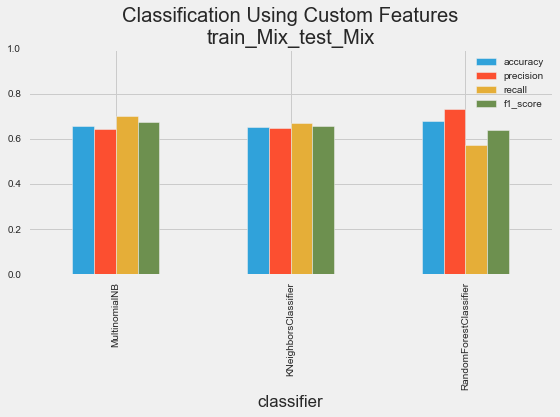

In [610]:
results_CUSTOM = pd.DataFrame(results_CUSTOM)
results_CUSTOM.columns = ['y', 'classifier', 'accuracy', 'precision', 'recall', 'f1_score']

for name, result in results_CUSTOM.groupby('y'):
    result.plot(x='classifier', kind='bar', ylim=[0,1], title='Classification Using Custom Features\n%s' % test_type, figsize=(8,6))
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/%s_CUSTOM.png' % test_type)

In [611]:
results_CUSTOM

,y,classifier,accuracy,precision,recall,f1_score
0,news,MultinomialNB,0.65651,0.646465,0.703297,0.673684
1,news,KNeighborsClassifier,0.65097,0.648936,0.670330,0.659459
2,news,RandomForestClassifier,0.67867,0.732394,0.571429,0.641975


### bag of words
#### chi-squared significant features

In [407]:
#chi-square eval
#vectorizer = TfidfVectorizer()
#trainBOW = vectorizer.fit_transform(train['text'])
#chi2 = sklearn.feature_selection.chi2(trainBOW, train[y])
#chi2 = pd.DataFrame.from_records(chi2, index=['x-square', 'p-value'], columns=vectorizer.get_feature_names()).T
#chi2[chi2['p-value'] < .05].sort_values(by='p-value')

In [408]:
#chi2.sort_values(by='p-value').head(25)

In [222]:
#xBOW_kbest = chi2.sort_values(by='p-value').index[:k]
#xBOW_kbest = [vectorizer.vocabulary_[token] for token in xBOW_kbest]
#trainBOW_kbest = trainBOW[:,xBOW_kbest]

#### execute

In [602]:
results_BOW = []
for clf in (MultinomialNB(), 
            KNeighborsClassifier(),
            #DecisionTreeClassifier(random_state=2016),
            RandomForestClassifier(random_state=2016),
            #svm.SVC()
            ):
    results_BOW.append(execute_BOW(clf, y))

________________________________________
>>>  MultinomialNB
  train time: 0.001s
  test time:  0.000s
________________________________________
Confusion Matrix: 
 Predicted  0.0  1.0  All
Actual                  
0.0        127   52  179
1.0         36  146  182
All        163  198  361

Report: 
              precision    recall  f1-score   support

        0.0       0.78      0.71      0.74       179
        1.0       0.74      0.80      0.77       182

avg / total       0.76      0.76      0.76       361

________________________________________
>>>  KNeighborsClassifier
  train time: 0.001s
  test time:  0.019s
________________________________________
Confusion Matrix: 
 Predicted  0.0  1.0  All
Actual                  
0.0        116   63  179
1.0         41  141  182
All        157  204  361

Report: 
              precision    recall  f1-score   support

        0.0       0.74      0.65      0.69       179
        1.0       0.69      0.77      0.73       182

avg / total       0

### BOW results

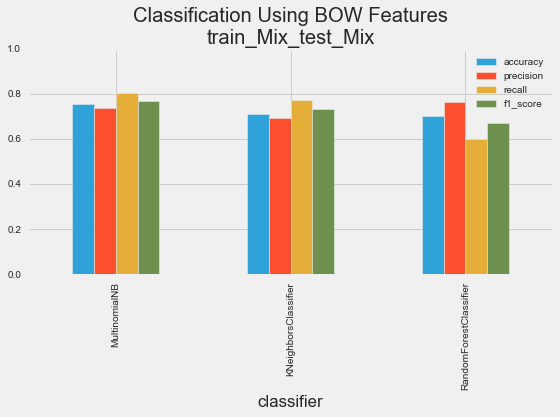

In [603]:
results_BOW = pd.DataFrame(results_BOW)
results_BOW.columns = ['y', 'classifier', 'accuracy', 'precision', 'recall', 'f1_score']

for name, result in results_BOW.groupby('y'):
    result.plot(x='classifier', kind='bar', ylim=[0,1], title='Classification Using BOW Features\n%s' % test_type, figsize=(8,6))
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/%s_BOW.png' % test_type)

In [604]:
results_BOW

,y,classifier,accuracy,precision,recall,f1_score
0,news,MultinomialNB,0.756233,0.737374,0.802198,0.768421
1,news,KNeighborsClassifier,0.711911,0.691176,0.774725,0.730570
2,news,RandomForestClassifier,0.703601,0.762238,0.598901,0.670769


#### analysis of bag of words

We learn that when training a classifier using a bag of words approach on one specific event, we can predict the news in that event to a high degree, and even with a precision up to 1. This is why this approach is so widely seen in literature. 

Although most research stops at their successful results and does not recognize how their findings may apply to the real world. The intentions of training a classifier on text is to be able to classify text which is unseen. The reasons the classifier did so well is due to the text in the testing corpus being so similar to that in the training corpus. The data was trained on a single event and test on the same event.

If we are apply this classifier to any different event the accuracy decreases significantly, to levels below the results of our custom features even. Similarily if we train the bag of words classifier using multiple events from different domains the results are also lower than our custom results. This shows how using the bag of words model, is not useful to predict anything outside of the domain it was classified in.

In [550]:
results_MIX = []
for clf in (MultinomialNB(), 
            KNeighborsClassifier(),
            #DecisionTreeClassifier(random_state=2016),
            RandomForestClassifier(random_state=2016),
            #svm.SVC()
            ):
    results_MIX.append(execute_MIX(clf, y))

________________________________________
>>>  MultinomialNB
  train time: 0.004s
  test time:  0.001s
________________________________________
Confusion Matrix: 
 Predicted  0.0  1.0  All
Actual                  
0.0        113   66  179
1.0         51  131  182
All        164  197  361

Report: 
              precision    recall  f1-score   support

        0.0       0.69      0.63      0.66       179
        1.0       0.66      0.72      0.69       182

avg / total       0.68      0.68      0.68       361

________________________________________
>>>  KNeighborsClassifier
  train time: 0.004s
  test time:  0.048s
________________________________________
Confusion Matrix: 
 Predicted  0.0  1.0  All
Actual                  
0.0        122   57  179
1.0         78  104  182
All        200  161  361

Report: 
              precision    recall  f1-score   support

        0.0       0.61      0.68      0.64       179
        1.0       0.65      0.57      0.61       182

avg / total       0

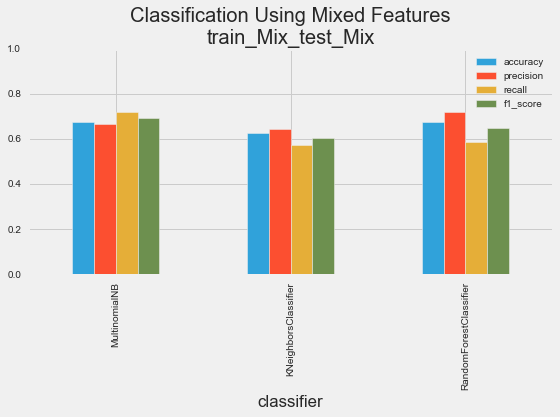

In [552]:
results_MIX = pd.DataFrame(results_MIX)
results_MIX.columns = ['y', 'classifier', 'accuracy', 'precision', 'recall', 'f1_score']

for name, result in results_MIX.groupby('y'):
    result.plot(x='classifier', kind='bar', ylim=[0,1], title='Classification Using Mixed Features\n%s' % test_type, figsize=(8,6))
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/%s_MIX.png' % test_type)

In [553]:
results_MIX

,y,classifier,accuracy,precision,recall,f1_score
0,news,MultinomialNB,0.675900,0.664975,0.719780,0.691293
1,news,KNeighborsClassifier,0.626039,0.645963,0.571429,0.606414
2,news,RandomForestClassifier,0.675900,0.718121,0.587912,0.646526
